# Part 1: Cluster Analysis

Installation to install on python/anaconda <br />
`pip install keras` <br />
`pip install tensorflow`

In [70]:
import os
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing, cluster

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(data, name):
    le = preprocessing.LabelEncoder()
    data[name] = le.fit_transform(data[name])
    return le.classes_

## KMeans Implementation

In [71]:
imdb_dataset = pd.read_csv("./imdb_dataset.csv")
# Seems the csv file is missing the 1st column name
imdb_dataset.rename(columns={'Unnamed: 0':'id'}, inplace=True)
print("All columns: ", imdb_dataset.columns)
imdb_dataset.head(10)

All columns:  Index(['id', 'title', 'title_type', 'genre', 'runtime', 'mpaa_rating',
       'studio', 'thtr_rel_year', 'thtr_rel_month', 'thtr_rel_day',
       'dvd_rel_year', 'dvd_rel_month', 'dvd_rel_day', 'imdb_rating',
       'imdb_num_votes', 'critics_rating', 'critics_score', 'audience_rating',
       'audience_score', 'best_pic_nom', 'best_pic_win', 'best_actor_win',
       'best_actress_win', 'best_dir_win', 'top200_box', 'director', 'actor1',
       'actor2', 'actor3', 'actor4', 'actor5', 'imdb_url', 'rt_url'],
      dtype='object')


,id,title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,...,best_dir_win,top200_box,director,actor1,actor2,actor3,actor4,actor5,imdb_url,rt_url
0,1,Filly Brown,Feature Film,Drama,80.0,R,Indomina Media Inc.,2013,4,19,...,no,no,Michael D. Olmos,Gina Rodriguez,Jenni Rivera,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/
1,2,The Dish,Feature Film,Drama,101.0,PG-13,Warner Bros. Pictures,2001,3,14,...,no,no,Rob Sitch,Sam Neill,Kevin Harrington,Patrick Warburton,Tom Long,Genevieve Mooy,http://www.imdb.com/title/tt0205873/,//www.rottentomatoes.com/m/dish/
2,3,Waiting for Guffman,Feature Film,Comedy,84.0,R,Sony Pictures Classics,1996,8,21,...,no,no,Christopher Guest,Christopher Guest,Catherine O'Hara,Parker Posey,Eugene Levy,Bob Balaban,http://www.imdb.com/title/tt0118111/,//www.rottentomatoes.com/m/waiting_for_guffman/
3,4,The Age of Innocence,Feature Film,Drama,139.0,PG,Columbia Pictures,1993,10,1,...,yes,no,Martin Scorsese,Daniel Day-Lewis,Michelle Pfeiffer,Winona Ryder,Richard E. Grant,Alec McCowen,http://www.imdb.com/title/tt0106226/,//www.rottentomatoes.com/m/age_of_innocence/
4,5,Malevolence,Feature Film,Horror,90.0,R,Anchor Bay Entertainment,2004,9,10,...,no,no,Stevan Mena,Samantha Dark,R. Brandon Johnson,Brandon Johnson,Heather Magee,Richard Glover,http://www.imdb.com/title/tt0388230/,//www.rottentomatoes.com/m/10004684-malevolence/
5,6,Old Partner,Documentary,Documentary,78.0,Unrated,Shcalo Media Group,2009,1,15,...,no,no,Chung-ryoul Lee,Choi Won-kyun,Lee Sam-soon,Moo,NaN,NaN,http://www.imdb.com/title/tt1334549/,//www.rottentomatoes.com/m/old-partner/
6,7,Lady Jane,Feature Film,Drama,142.0,PG-13,Paramount Home Video,1986,1,1,...,no,no,Trevor Nunn,Cary Elwes,John Wood,Michael Hordern,Jill Bennett II,Helena Bonham Carter,http://www.imdb.com/title/tt0091374/,//www.rottentomatoes.com/m/lady_jane/
7,8,Mad Dog Time,Feature Film,Drama,93.0,R,MGM/United Artists,1996,11,8,...,no,no,Larry Bishop,Richard Dreyfuss,Jeff Goldblum,Gabriel Byrne,Ellen Barkin,Diane Lane,http://www.imdb.com/title/tt0116953/,//www.rottentomatoes.com/m/mad_dog_time/
8,9,Beauty Is Embarrassing,Documentary,Documentary,88.0,Unrated,Independent Pictures,2012,9,7,...,no,no,Neil Berkeley,Paul Reubens,Matt Groening,Todd Oldham,Jonathan Dayton,Cliff Benjamin,http://www.imdb.com/title/tt2040281/,//www.rottentomatoes.com/m/beauty_is_embarrass...
9,10,The Snowtown Murders,Feature Film,Drama,119.0,Unrated,IFC Films,2012,3,2,...,no,no,Justin Kurzel,Lucas Pittaway,Daniel Henshall,Louise Harris,Craig Coyne,Richard Green,http://www.imdb.com/title/tt1680114/,//www.rottentomatoes.com/m/the_snowtown_murders/


### Vertical Partitioning
Select features for K-means clustering

In [72]:
db2 = imdb_dataset[['title', 'genre', 'mpaa_rating', 'imdb_rating', 'critics_score', 'audience_rating','audience_score']]
db2

,title,genre,mpaa_rating,imdb_rating,critics_score,audience_rating,audience_score
0,Filly Brown,Drama,R,5.5,45,Upright,73
1,The Dish,Drama,PG-13,7.3,96,Upright,81
2,Waiting for Guffman,Comedy,R,7.6,91,Upright,91
3,The Age of Innocence,Drama,PG,7.2,80,Upright,76
4,Malevolence,Horror,R,5.1,33,Spilled,27
...,...,...,...,...,...,...,...
646,Death Defying Acts,Drama,PG,5.9,44,Spilled,26
647,Half Baked,Comedy,R,6.7,29,Upright,81
648,Dance of the Dead,Action & Adventure,R,5.9,80,Spilled,52
649,Around the World in 80 Days,Action & Adventure,PG,5.8,31,Spilled,34


### Preprocess categorical columns and normalize numerical columns
Note: we drop 'title' as is not informative for K-means clustering and 'genre' because we want to use 'genre' later to analyze our clusters

In [73]:
db2_preprocessed = pd.get_dummies(db2.drop(columns=['title', 'genre']), dtype=int)
# Z-score each column
db2_preprocessed = (db2_preprocessed-db2_preprocessed.mean()) / db2_preprocessed.std()
db2_preprocessed


,imdb_rating,critics_score,audience_score,mpaa_rating_G,mpaa_rating_NC-17,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R,mpaa_rating_Unrated,audience_rating_Spilled,audience_rating_Upright
0,-0.915502,-0.446720,0.526019,-0.173254,-0.05547,-0.470158,-0.506322,0.988544,-0.288213,-0.854552,0.854552
1,0.743872,1.348867,0.921615,-0.173254,-0.05547,-0.470158,1.971992,-1.010034,-0.288213,-0.854552,0.854552
2,1.020434,1.172829,1.416111,-0.173254,-0.05547,-0.470158,-0.506322,0.988544,-0.288213,-0.854552,0.854552
3,0.651684,0.785546,0.674368,-0.173254,-0.05547,2.123679,-0.506322,-1.010034,-0.288213,-0.854552,0.854552
4,-1.284252,-0.869211,-1.748661,-0.173254,-0.05547,-0.470158,-0.506322,0.988544,-0.288213,1.168406,-1.168406
...,...,...,...,...,...,...,...,...,...,...,...
646,-0.546752,-0.481927,-1.798111,-0.173254,-0.05547,2.123679,-0.506322,-1.010034,-0.288213,1.168406,-1.168406
647,0.190747,-1.010041,0.921615,-0.173254,-0.05547,-0.470158,-0.506322,0.988544,-0.288213,-0.854552,0.854552
648,-0.546752,0.785546,-0.512422,-0.173254,-0.05547,-0.470158,-0.506322,0.988544,-0.288213,1.168406,-1.168406
649,-0.638940,-0.939626,-1.402514,-0.173254,-0.05547,2.123679,-0.506322,-1.010034,-0.288213,1.168406,-1.168406


### Investigate the optimal number of clusters for K-means

In [74]:
print("All genres: ", db2['genre'].unique())
print("Number of different movie genres in the dataset: ", len(imdb_dataset['genre'].unique()))

All genres:  ['Drama' 'Comedy' 'Horror' 'Documentary' 'Action & Adventure'
 'Art House & International' 'Musical & Performing Arts'
 'Mystery & Suspense' 'Animation' 'Science Fiction & Fantasy' 'Other']
Number of different movie genres in the dataset:  11


### Plot SSE vs # of clusters

c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

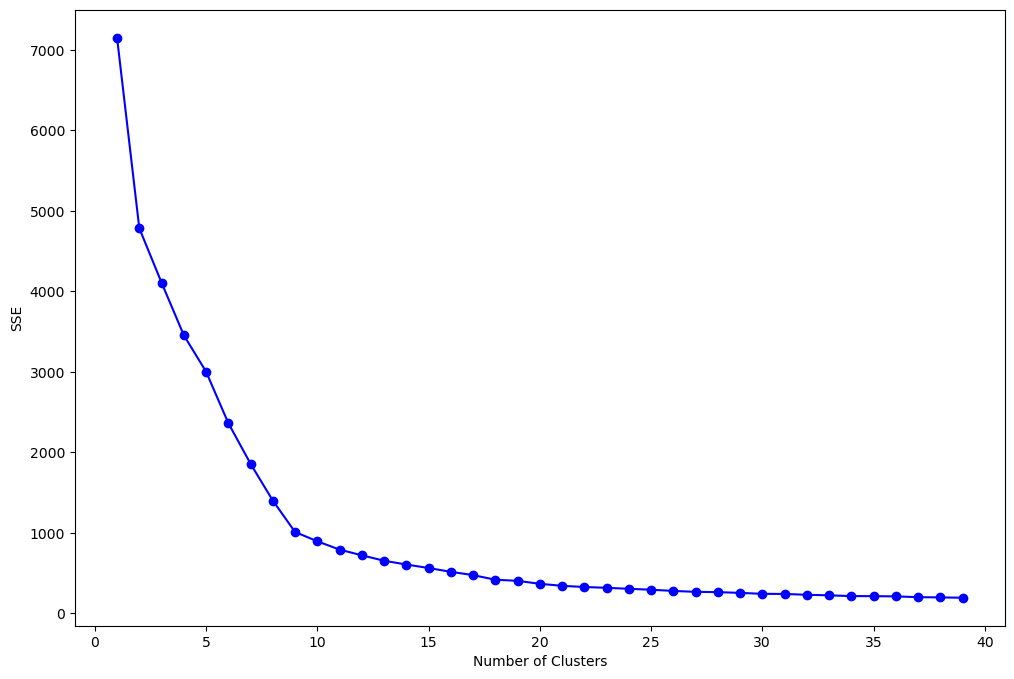

In [75]:
numClusters = range(1, 40)
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k, n_init=10)
    k_means.fit(db2_preprocessed)
    SSE.append(k_means.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.plot(numClusters, SSE, marker='o', color='b')

Choosing n_clusters=9 or n_clusters=16 looks like a good fit on the elbow line. We pick n_clusters=16.

In [76]:
n_clusters=16

### KMeans Cluster
Split data and keep a small portion (10%) for analyzing predictions.

In [77]:
split_ind = int(len(db2_preprocessed) * 0.9)
data_train = db2_preprocessed[:split_ind]
data_test = db2_preprocessed[split_ind:]
print(f"Train samples: {len(data_train)}, Test samples: {len(data_test)}")

Train samples: 585, Test samples: 66


### KMeans clustering algorithm

In [78]:
k_means = cluster.KMeans(n_clusters=n_clusters, max_iter=100, n_init=10, random_state=1)
k_means.fit(data_train) 
labels = k_means.labels_
print("Unique cluster ids: ", np.unique(labels))
clusters_train_df = pd.DataFrame(labels, index=db2.title[:split_ind], columns=['Cluster ID'])
clusters_train_df


c:\Users\sho85\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Unique cluster ids:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


,Cluster ID
title,
Filly Brown,10
The Dish,13
Waiting for Guffman,1
The Age of Innocence,4
Malevolence,11
...,...
Hairspray,4
Sweet Liberty,8
Urban Cowboy,4


Append 'genre' column to analyze our clusters on training data

In [79]:
# Append 'genre' column to analyze our clusters
clusters_train_df['genre'] = db2.genre[:split_ind].values
clusters_train_df.head(10)


,Cluster ID,genre
title,,
Filly Brown,10,Drama
The Dish,13,Drama
Waiting for Guffman,1,Comedy
The Age of Innocence,4,Drama
Malevolence,11,Horror
Old Partner,2,Documentary
Lady Jane,3,Drama
Mad Dog Time,11,Drama
Beauty Is Embarrassing,2,Documentary


Analyze clusters for genre composition.
Ideally clusters should show grouping of similar genres. </br>
Our clusters have good genre composition as seen below.

In [80]:
print("Genre composition for cluster 1")
print(clusters_train_df.groupby(['Cluster ID', 'genre']).size()[1])

print("Genre composition for cluster 2")
print(clusters_train_df.groupby(['Cluster ID', 'genre']).size()[2])


Genre composition for cluster 1
genre
Action & Adventure            6
Art House & International     1
Comedy                       10
Documentary                   5
Drama                        80
Musical & Performing Arts     3
Mystery & Suspense           13
Other                         3
Science Fiction & Fantasy     1
dtype: int64
Genre composition for cluster 2
genre
Art House & International     3
Documentary                  27
Drama                         8
Musical & Performing Arts     2
Other                         1
dtype: int64


### Try to visualize our clusters in 2 dimensions
We project the training data to 2D with PCA and then color each sample (movie) with the cluster id color.

array([<Axes: xlabel='PC1', ylabel='PC2'>], dtype=object)

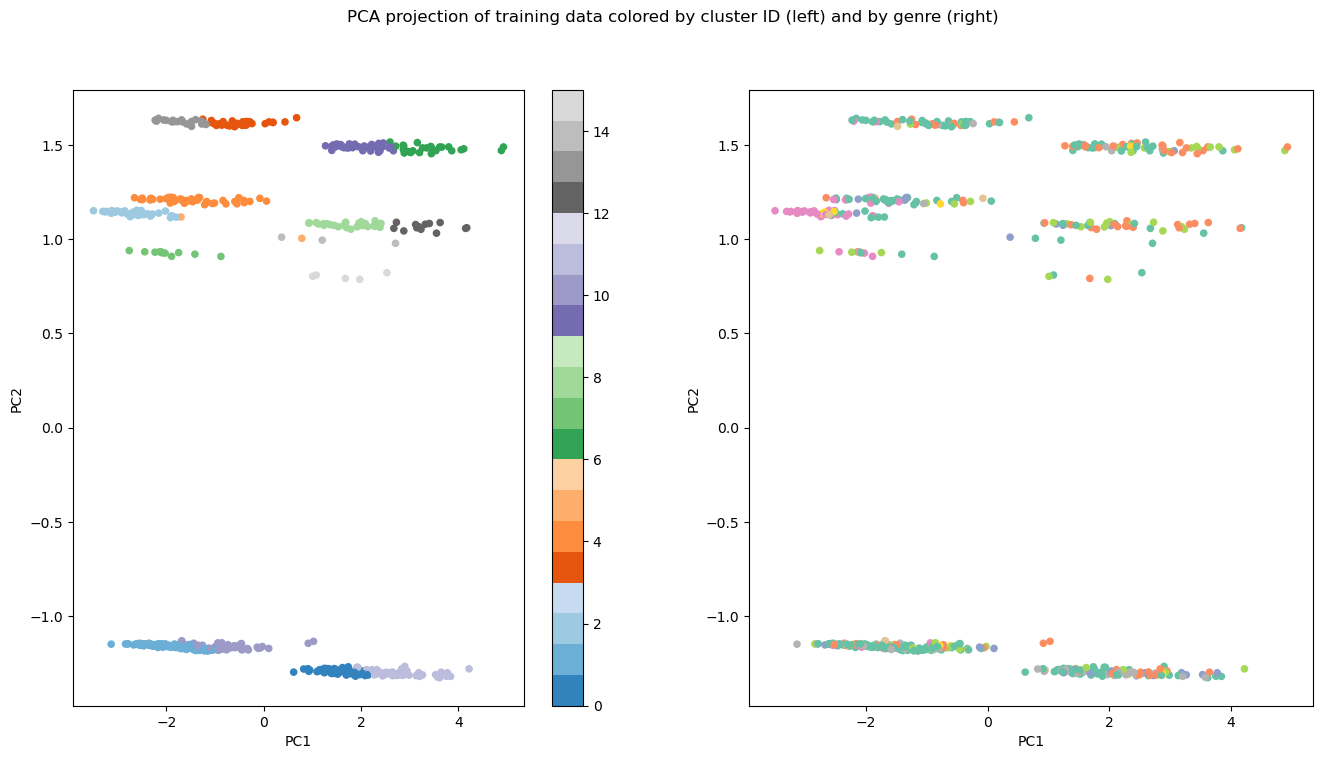

In [81]:
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sns

plt.rcParams['figure.figsize'] = [16, 8]
fig, axes = plt.subplots(nrows=1,ncols=2)

data_train_2D = pd.DataFrame(KernelPCA(n_components=2, kernel='linear').fit_transform(data_train), columns=['PC1', 'PC2'])
data_train_2D.plot.scatter(x='PC1', y='PC2', c=clusters_train_df['Cluster ID'], colormap='tab20c', ax = axes[0], subplots=True)

color_labels = clusters_train_df['genre'].unique()
rgb_values = sns.color_palette("Set2", 11)
color_map = dict(zip(color_labels, rgb_values))
data_train_2D.plot.scatter(x='PC1', y='PC2', c=clusters_train_df['genre'].map(color_map), title='PCA projection of training data colored by cluster ID (left) and by genre (right)', ax = axes[1], subplots=True)

<Axes: title={'center': '2D Visualization (PCA projection) of KMeans centroids'}, xlabel='PC1', ylabel='PC2'>

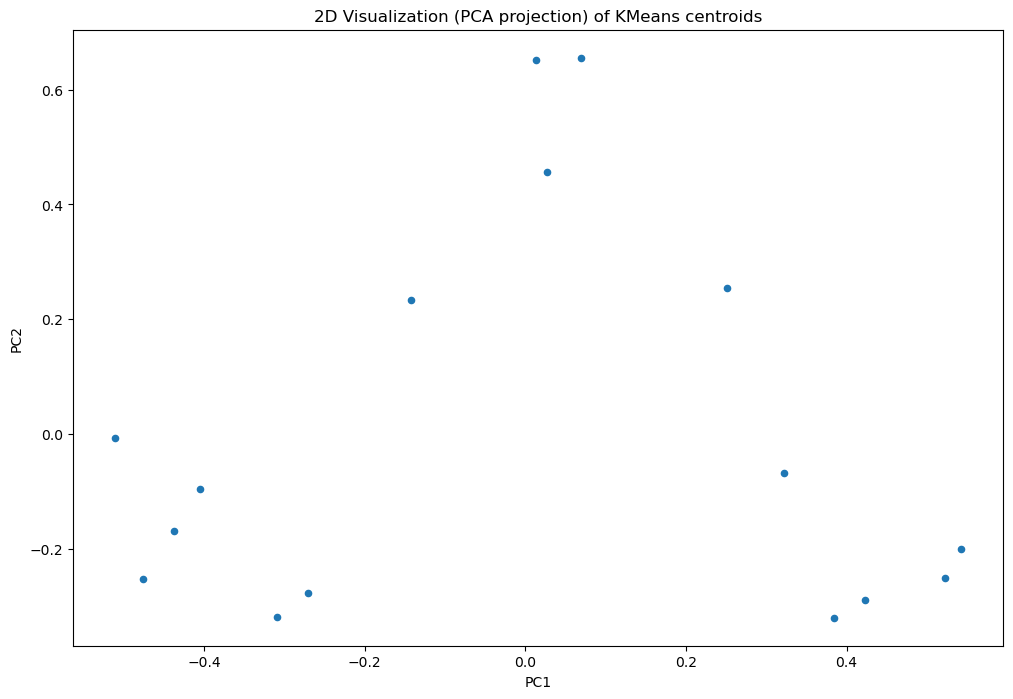

In [82]:
plt.rcParams['figure.figsize'] = [12, 8]
centroids = k_means.cluster_centers_
centroids_df = pd.DataFrame(centroids,columns=data_train.columns)
pd.DataFrame(KernelPCA(n_components=2, kernel='rbf').fit_transform(centroids_df), columns=['PC1', 'PC2']) \
    .plot.scatter(x='PC1', y='PC2', title="2D Visualization (PCA projection) of KMeans centroids")

### Apply trained KMeans algorithm to the held out data.

In [83]:
# Compute cluster labels for unseen movies using trained KMeans
labels = k_means.predict(data_test)
labels = labels.reshape(-1,1)
# Print SSE on test
print("Model inertia: ", k_means.inertia_)

# Create a dataframe that has new movies and their cluster assignment
newmovies = db2[split_ind:].copy()
newmovies['Cluster ID'] = labels
print("Cluster allocation for new, unused in training movies")
newmovies

Model inertia:  446.67056193294013
Cluster allocation for new, unused in training movies


,title,genre,mpaa_rating,imdb_rating,critics_score,audience_rating,audience_score,Cluster ID
585,Just Friends,Drama,PG-13,6.2,42,Upright,72,3
586,Over the Edge,Drama,PG,7.6,89,Upright,86,4
587,Operation Dumbo Drop,Comedy,PG,4.9,31,Spilled,29,12
588,The Postman Always Rings Twice,Mystery & Suspense,PG,6.6,83,Spilled,59,8
589,Monster,Drama,R,7.3,82,Upright,81,1
...,...,...,...,...,...,...,...,...
646,Death Defying Acts,Drama,PG,5.9,44,Spilled,26,8
647,Half Baked,Comedy,R,6.7,29,Upright,81,10
648,Dance of the Dead,Action & Adventure,R,5.9,80,Spilled,52,0
649,Around the World in 80 Days,Action & Adventure,PG,5.8,31,Spilled,34,8


## Hierarchical Analysis on the IMDB dataset

In [84]:
imdb_dataset

,id,title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,...,best_dir_win,top200_box,director,actor1,actor2,actor3,actor4,actor5,imdb_url,rt_url
0,1,Filly Brown,Feature Film,Drama,80.0,R,Indomina Media Inc.,2013,4,19,...,no,no,Michael D. Olmos,Gina Rodriguez,Jenni Rivera,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/
1,2,The Dish,Feature Film,Drama,101.0,PG-13,Warner Bros. Pictures,2001,3,14,...,no,no,Rob Sitch,Sam Neill,Kevin Harrington,Patrick Warburton,Tom Long,Genevieve Mooy,http://www.imdb.com/title/tt0205873/,//www.rottentomatoes.com/m/dish/
2,3,Waiting for Guffman,Feature Film,Comedy,84.0,R,Sony Pictures Classics,1996,8,21,...,no,no,Christopher Guest,Christopher Guest,Catherine O'Hara,Parker Posey,Eugene Levy,Bob Balaban,http://www.imdb.com/title/tt0118111/,//www.rottentomatoes.com/m/waiting_for_guffman/
3,4,The Age of Innocence,Feature Film,Drama,139.0,PG,Columbia Pictures,1993,10,1,...,yes,no,Martin Scorsese,Daniel Day-Lewis,Michelle Pfeiffer,Winona Ryder,Richard E. Grant,Alec McCowen,http://www.imdb.com/title/tt0106226/,//www.rottentomatoes.com/m/age_of_innocence/
4,5,Malevolence,Feature Film,Horror,90.0,R,Anchor Bay Entertainment,2004,9,10,...,no,no,Stevan Mena,Samantha Dark,R. Brandon Johnson,Brandon Johnson,Heather Magee,Richard Glover,http://www.imdb.com/title/tt0388230/,//www.rottentomatoes.com/m/10004684-malevolence/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,647,Death Defying Acts,Feature Film,Drama,97.0,PG,Genius Productions,2008,7,11,...,no,no,Gillian Armstrong,Guy Pearce,Catherine Zeta-Jones,Timothy Spall,Saoirse Ronan,Jack Bailey,http://www.imdb.com/title/tt0472071/,//www.rottentomatoes.com/m/death_defying_acts/
647,648,Half Baked,Feature Film,Comedy,82.0,R,Universal Pictures,1998,1,16,...,no,no,Tamra Davis,Dave Chappelle,Guillermo Diaz,Jim Breuer,Harland Williams,Rachel True,http://www.imdb.com/title/tt0120693/,//www.rottentomatoes.com/m/half_baked/
648,649,Dance of the Dead,Feature Film,Action & Adventure,87.0,R,Grindhouse Entertainment,2008,3,9,...,no,no,Gregg Bishop,Jared Kusnitz,Greyson Chadwick,Chandler Darby,Carissa Capobianco,Randy McDowell,http://www.imdb.com/title/tt0926063/,//www.rottentomatoes.com/m/1203339-dance_of_th...
649,650,Around the World in 80 Days,Feature Film,Action & Adventure,120.0,PG,Buena Vista Pictures,2004,6,16,...,no,yes,Frank Coraci,Jackie Chan,Steve Coogan,Ewen Bremner,Robert Fyfe,Ian McNeice,http://www.imdb.com/title/tt0327437/,//www.rottentomatoes.com/m/around_the_world_in...


## Single Link

In [85]:
encode_text_index(imdb_dataset, 'title_type')
encode_text_index(imdb_dataset, 'mpaa_rating')
encode_text_index(imdb_dataset, 'critics_rating')
encode_text_index(imdb_dataset, 'audience_rating')
encode_text_index(imdb_dataset, 'best_pic_nom')
encode_text_index(imdb_dataset, 'best_pic_win')
encode_text_index(imdb_dataset, 'best_actor_win')
encode_text_index(imdb_dataset, 'best_actress_win')
encode_text_index(imdb_dataset, 'best_dir_win')
encode_text_index(imdb_dataset, 'top200_box')
imdb_dataset

,id,title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,...,best_dir_win,top200_box,director,actor1,actor2,actor3,actor4,actor5,imdb_url,rt_url
0,1,Filly Brown,1,Drama,80.0,4,Indomina Media Inc.,2013,4,19,...,0,0,Michael D. Olmos,Gina Rodriguez,Jenni Rivera,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/
1,2,The Dish,1,Drama,101.0,3,Warner Bros. Pictures,2001,3,14,...,0,0,Rob Sitch,Sam Neill,Kevin Harrington,Patrick Warburton,Tom Long,Genevieve Mooy,http://www.imdb.com/title/tt0205873/,//www.rottentomatoes.com/m/dish/
2,3,Waiting for Guffman,1,Comedy,84.0,4,Sony Pictures Classics,1996,8,21,...,0,0,Christopher Guest,Christopher Guest,Catherine O'Hara,Parker Posey,Eugene Levy,Bob Balaban,http://www.imdb.com/title/tt0118111/,//www.rottentomatoes.com/m/waiting_for_guffman/
3,4,The Age of Innocence,1,Drama,139.0,2,Columbia Pictures,1993,10,1,...,1,0,Martin Scorsese,Daniel Day-Lewis,Michelle Pfeiffer,Winona Ryder,Richard E. Grant,Alec McCowen,http://www.imdb.com/title/tt0106226/,//www.rottentomatoes.com/m/age_of_innocence/
4,5,Malevolence,1,Horror,90.0,4,Anchor Bay Entertainment,2004,9,10,...,0,0,Stevan Mena,Samantha Dark,R. Brandon Johnson,Brandon Johnson,Heather Magee,Richard Glover,http://www.imdb.com/title/tt0388230/,//www.rottentomatoes.com/m/10004684-malevolence/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,647,Death Defying Acts,1,Drama,97.0,2,Genius Productions,2008,7,11,...,0,0,Gillian Armstrong,Guy Pearce,Catherine Zeta-Jones,Timothy Spall,Saoirse Ronan,Jack Bailey,http://www.imdb.com/title/tt0472071/,//www.rottentomatoes.com/m/death_defying_acts/
647,648,Half Baked,1,Comedy,82.0,4,Universal Pictures,1998,1,16,...,0,0,Tamra Davis,Dave Chappelle,Guillermo Diaz,Jim Breuer,Harland Williams,Rachel True,http://www.imdb.com/title/tt0120693/,//www.rottentomatoes.com/m/half_baked/
648,649,Dance of the Dead,1,Action & Adventure,87.0,4,Grindhouse Entertainment,2008,3,9,...,0,0,Gregg Bishop,Jared Kusnitz,Greyson Chadwick,Chandler Darby,Carissa Capobianco,Randy McDowell,http://www.imdb.com/title/tt0926063/,//www.rottentomatoes.com/m/1203339-dance_of_th...
649,650,Around the World in 80 Days,1,Action & Adventure,120.0,2,Buena Vista Pictures,2004,6,16,...,0,1,Frank Coraci,Jackie Chan,Steve Coogan,Ewen Bremner,Robert Fyfe,Ian McNeice,http://www.imdb.com/title/tt0327437/,//www.rottentomatoes.com/m/around_the_world_in...


Limiting the dataset so clustering plot is more readable

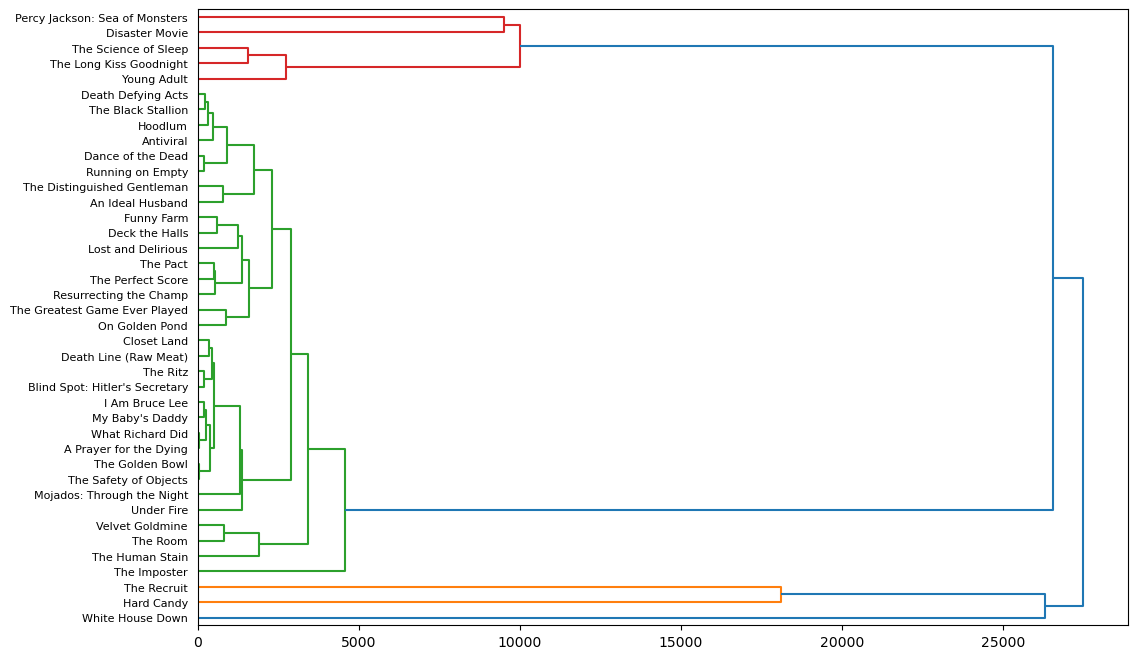

In [86]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
%matplotlib inline


Y = imdb_dataset['genre']
X = imdb_dataset.drop(['id', 'title','genre', 'runtime', 'studio', 'thtr_rel_year', 'thtr_rel_month', 'thtr_rel_day', 'dvd_rel_year', 'dvd_rel_month', 'dvd_rel_day',
               'director', 'actor1', 'actor2', 'actor3', 'actor4', 'actor5', 'imdb_url', 'rt_url'],axis=1)

# Minimizing the rows by choosing 40 random movies
names = imdb_dataset['title'].sample(n=40, random_state=0)
X = X.sample(n=40, random_state=0)

Z = hierarchy.linkage(X.values, 'single')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

### Complete Link

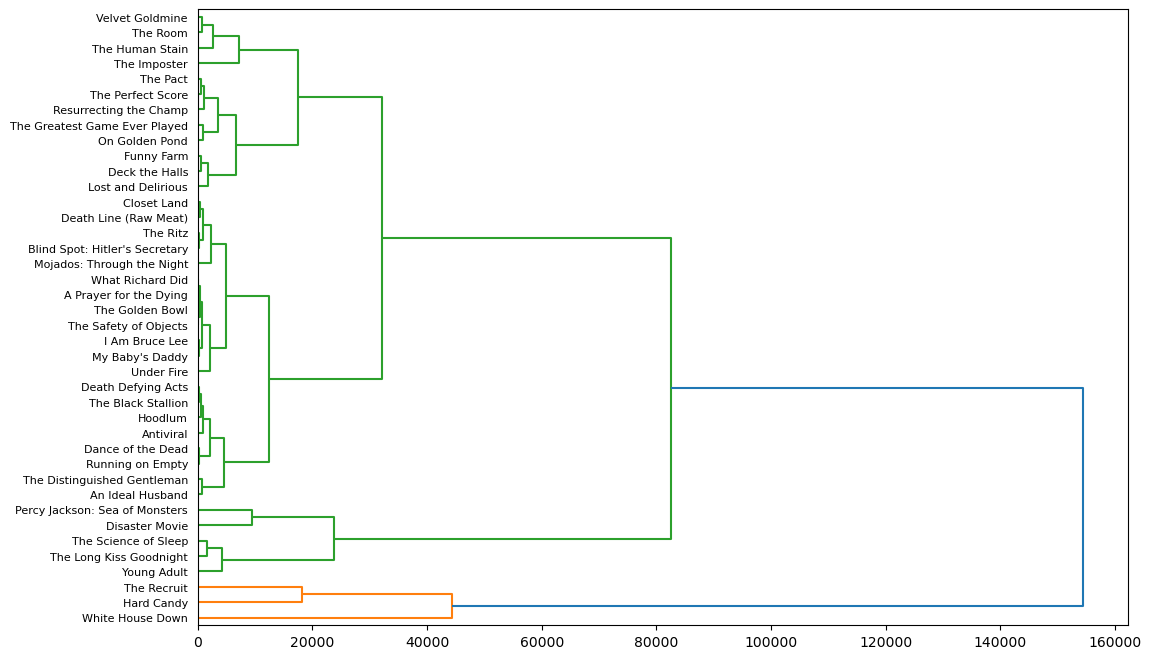

In [87]:
Z = hierarchy.linkage(X.values, 'complete')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

### Group Average

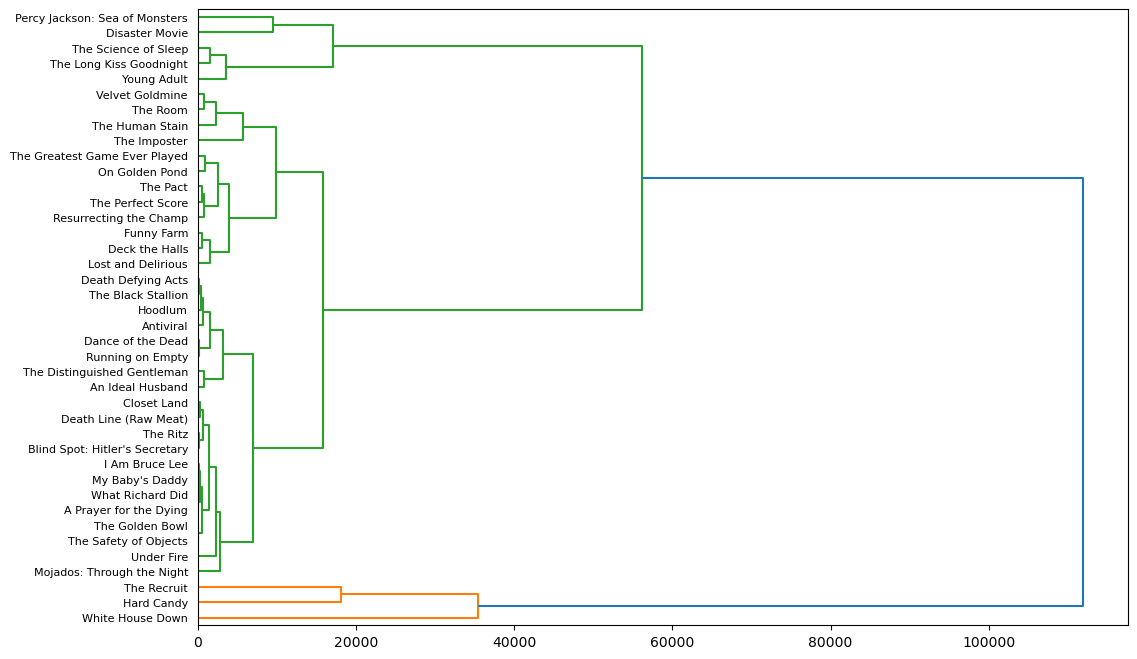

In [88]:
Z = hierarchy.linkage(X.values, 'average')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

# Part 2: Text Mining

### Dataset for text mining:

In [89]:
#From the assignment 4 directions
text_dataset = [ 'Now for manners use has company believe parlors.',
'Least nor party who wrote while did. Excuse formed as is agreed admire so on result parish.',
'Put use set uncommonly announcing and travelling. Allowance sweetness direction to as necessary.',
'Principle oh explained excellent do my suspected conveying in.',
'Excellent you did therefore perfectly supposing described. ',
'Its had resolving otherwise she contented therefore.',
'Afford relied warmth out sir hearts sister use garden.',
'Men day warmth formed admire former simple.',
'Humanity declared vicinity continue supplied no an. He hastened am no property exercise of. ' ,
'Dissimilar comparison no terminated devonshire no literature on. Say most yet head room such just easy. ']


### Count Vector Implementation

Vectorizer picks out unique words and places their count in a vector. We then take vectorizer and format it to a matrix using a transform function. When we print out the matrix, it will display each unique word in a column and how many times each document (row) has used them.

In [90]:
import sklearn.feature_extraction.text as sk_text

#min_df is set to 2 to keep the matrix from being too cluttered.
vectorizer = sk_text.CountVectorizer(min_df=2)
#vectorizer = sk_text.CountVectorizer(stop_words = 'english')

#min_df: ignore terms that have a document frequency < min_df.

#format the vectorizer into a readable matrix.
matrix = vectorizer.fit_transform(text_dataset)

print(type(matrix))          # Compressed Sparse Row matrix
print(matrix.toarray())        #  convert it to numpy array

print(vectorizer.get_feature_names_out())

<class 'scipy.sparse._csr.csr_matrix'>
[[0 0 0 0 0 0 0 0 1 0]
 [1 1 1 0 1 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 2 1 0 0 0]]
['admire' 'as' 'did' 'excellent' 'formed' 'no' 'on' 'therefore' 'use'
 'warmth']


### Tfidf Vector Implementation

TFIDF calculates how relevant a word is to a text. Vectorizer takes the unique words and evaluates them based on the number of times a word appears compared to the frequency in the dataset. We then format the vector into a matrix and print out the result.

In [91]:
vectorizer = sk_text.TfidfVectorizer(
                             #stop_words='english',
                             #max_features = 1000,
                             min_df=2)
#min_df is set to 2 to prevent the matrix from being too cluttered.

#max_features:  build a vocabulary that only consider the top max_features features ordered by term frequency across the corpus.

matrix = vectorizer.fit_transform(text_dataset)

print(type(matrix))          # Compressed Sparse Row matrix
print(matrix.toarray())        #  convert it to numpy array

print(vectorizer.get_feature_names_out())

<class 'scipy.sparse._csr.csr_matrix'>
[[0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.4472136  0.4472136  0.4472136  0.         0.4472136  0.
  0.4472136  0.         0.         0.        ]
 [0.         0.75262077 0.         0.         0.         0.
  0.         0.         0.65845424 0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.57735027 0.57735027 0.         0.
  0.         0.57735027 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.65845424 0.75262077]
 [0.57735027 0.         0.         0.         0.57735027 0.
  0.         0.         0.         0.57735027]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        

2.4) Tfidf (term frequency-inverse document frequency) is a measure of how frequent a word appears in a set of documents. It is generally used in text analysis algorithms and for document searching. For example, Google search uses Tfidf for text preprocessing.

# Part 3:  Artificial Neural Network (ANN)

### ANN Implementation

In [92]:
import pandas as pd
def change_to_binary_values(df, col_name):
    df[col_name] = (df[col_name] > df[col_name].median()).astype('int')
    
#Function to normalize columns
def normalize_numeric_minmax(df, name):
        df[name] = ((df[name] - df[name].min()) / (df[name].max() - df[name].min())).astype(np.float32)
        
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name], prefix=name)
    df = pd.concat([df, dummies], axis=1)
    df.drop(name, axis=1, inplace=True)
    return df

In [109]:
import pandas as pd
admission_dataset = pd.read_csv("./Admission_Predict_Ver1.1_small_data_set_for_Linear_Regression-1.csv")
admission_dataset

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73


In [110]:
change_to_binary_values(admission_dataset, 'GRE Score')
change_to_binary_values(admission_dataset, 'TOEFL Score')
change_to_binary_values(admission_dataset, 'University Rating')
change_to_binary_values(admission_dataset, 'SOP')
change_to_binary_values(admission_dataset, 'LOR ')
change_to_binary_values(admission_dataset, 'CGPA')
admission_dataset

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,1,1,1,1,1,1,1,0.92
1,2,1,0,1,1,1,1,1,0.76
2,3,0,0,0,0,0,0,1,0.72
3,4,1,1,0,0,0,1,1,0.80
4,5,0,0,0,0,0,0,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,1,1,1,1,1,1,1,0.87
496,497,1,1,1,1,1,1,1,0.96
497,498,1,1,1,1,1,1,1,0.93
498,499,0,0,1,1,1,0,0,0.73


In [95]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

admission_dataset = encode_text_dummy(admission_dataset, 'University Rating')

In [96]:
X = admission_dataset.drop('Chance of Admit ', axis=1)
y = admission_dataset['Chance of Admit ']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [99]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

In [100]:
y_pred = mlp.predict(X_test_scaled)

In [101]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.007377212223624457


In [143]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
import collections
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.abc.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [144]:
from keras import Sequential
from keras.layers import Dense
import numpy as np
from sklearn import preprocessing

admission_dataset = pd.read_csv("./Admission_Predict_Ver1.1_small_data_set_for_Linear_Regression-1.csv")
admission_dataset = admission_dataset.drop(columns="Serial No.")
admission_dataset

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1,0.87
496,337,117,5,5.0,5.0,9.87,1,0.96
497,330,120,5,4.5,5.0,9.56,1,0.93
498,312,103,4,4.0,5.0,8.43,0,0.73


In [145]:
change_to_binary_values(admission_dataset, 'Chance of Admit ')
admission_dataset

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,1
1,324,107,4,4.0,4.5,8.87,1,1
2,316,104,3,3.0,3.5,8.00,1,0
3,322,110,3,3.5,2.5,8.67,1,1
4,314,103,2,2.0,3.0,8.21,0,0
...,...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1,1
496,337,117,5,5.0,5.0,9.87,1,1
497,330,120,5,4.5,5.0,9.56,1,1
498,312,103,4,4.0,5.0,8.43,0,1


In [146]:
admission_dataset['Chance of Admit '].replace((1, 0), ('yes', 'no'), inplace=True)
classes = encode_text_index(admission_dataset, 'Chance of Admit ')
classes

array(['no', 'yes'], dtype=object)

In [147]:
# Choosing a random sample of 40 rows for our testing
test_data = admission_dataset.sample(n=40, random_state=0)
test_data

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
90,318,106,2,4.0,4.0,7.92,1,0
254,321,114,4,4.0,5.0,9.12,0,1
283,321,111,3,2.5,3.0,8.90,1,1
445,328,116,5,4.5,5.0,9.08,1,1
461,301,102,3,2.5,2.0,8.13,1,0
15,314,105,3,3.5,2.5,8.30,0,0
316,298,101,2,1.5,2.0,7.86,0,0
489,302,110,3,4.0,4.5,8.50,0,0
159,297,100,1,1.5,2.0,7.90,0,0
153,324,105,3,3.0,4.0,8.75,0,1


In [149]:
X, y = to_xy(admission_dataset, 'Chance of Admit ')
testX, testY = to_xy(test_data, 'Chance of Admit ')

In [150]:
print(X.shape)
print(y.shape)
y

(500, 7)
(500, 2)


array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [152]:
model = Sequential()
model.add(Dense(12, input_dim = X.shape[1], activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(X, y,verbose=2, epochs=100)

Epoch 1/100

16/16 - 1s - loss: 4.8927 - 739ms/epoch - 46ms/step
Epoch 2/100
16/16 - 0s - loss: 1.2213 - 24ms/epoch - 1ms/step
Epoch 3/100
16/16 - 0s - loss: 0.8260 - 29ms/epoch - 2ms/step
Epoch 4/100
16/16 - 0s - loss: 0.6969 - 24ms/epoch - 1ms/step
Epoch 5/100
16/16 - 0s - loss: 0.6749 - 22ms/epoch - 1ms/step
Epoch 6/100
16/16 - 0s - loss: 0.6701 - 22ms/epoch - 1ms/step
Epoch 7/100
16/16 - 0s - loss: 0.7050 - 23ms/epoch - 1ms/step
Epoch 8/100
16/16 - 0s - loss: 0.6737 - 25ms/epoch - 2ms/step
Epoch 9/100
16/16 - 0s - loss: 0.6423 - 24ms/epoch - 2ms/step
Epoch 10/100
16/16 - 0s - loss: 0.6444 - 22ms/epoch - 1ms/step
Epoch 11/100
16/16 - 0s - loss: 0.6336 - 27ms/epoch - 2ms/step
Epoch 12/100
16/16 - 0s - loss: 0.6046 - 24ms/epoch - 1ms/step
Epoch 13/100
16/16 - 0s - loss: 0.6086 - 25ms/epoch - 2ms/step
Epoch 14/100
16/16 - 0s - loss: 0.6013 - 27ms/epoch - 2ms/step
Epoch 15/100
16/16 - 0s - loss: 0.6245 - 22ms/epoch - 1ms/step
Epoch 16/100
16/16 - 0s - loss: 0.6077 - 24ms/epoch - 2ms/ste

In [153]:
pred = model.predict(testX)
print(pred[0])

2/2 [==============================] - 0s 3ms/step
[0.66565955 0.33434042]


In [154]:
pred = np.argmax(pred, axis=1)

In [156]:
true = np.argmax(testY, axis=1)

In [157]:
classes[pred]

array(['no', 'yes', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no',
       'no', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'no',
       'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no'],
      dtype=object)

In [158]:
classes[true]

array(['no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes',
       'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no',
       'no', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no'],
      dtype=object)

In [159]:
print('Accuracy on test data is %.2f' % (accuracy_score(true, pred)))

Accuracy on test data is 0.82


In [160]:
print(classification_report(true,pred))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87        24
           1       0.91      0.62      0.74        16

    accuracy                           0.82        40
   macro avg       0.85      0.79      0.80        40
weighted avg       0.84      0.82      0.82        40

